In [1]:
import pandas as pd
import os
import re
import geopandas as gpd
from copy import deepcopy

In [2]:
dfps_crosswalk = pd.read_csv('/Users/kpierce/demographic-toolkit/DFPSRegion_County_Crosswalk.csv', dtype={'fips': str})

def dfps_agg(raw_df, agg_columns, percentages_map=None):
    
    dfps_df = pd.merge(raw_df, dfps_crosswalk, left_on='GEOID', right_on='fips')
    dfps_df = dfps_df.groupby(['DFPS_Region', 'YEAR'])[agg_columns].sum().reset_index()
    
    if percentages_map:
        for key, value in percentages_map.items():
            est_re = re.compile(r'^E_')
            pct_name = re.sub(est_re, 'EP_', key)
            dfps_df[pct_name] = (dfps_df[key] / dfps_df[value]) * 100
    
    # clean up DFPS region names
    dfps_names = {
        1: '1-Lubbock',
        2: '2-Abilene',
        3: '3-Arlington',
        4: '4-Tyler',
        5: '5-Beaumont',
        6: '6-Houston',
        7: '7-Austin',
        8: '8-San Antonio',
        9: '9-Midland',
        10: '10-El Paso',
        11: '11-Edinburg'
    }

    dfps_df['GEOID'] = [dfps_names[i] for i in dfps_df['DFPS_Region']]
    dfps_df['GEO_TYPE'] = 'dfps_region'
    
    return dfps_df

def zcta_svi(zcta_df, state='48'):
    
    zcta_df['state'] = [str(i)[0:2] if len(i) == 7 else None for i in zcta_df['GEOID']]
    zcta_df['GEOID'] = [str(i)[2:len(i)] if len(i) == 7 else i for i in zcta_df['GEOID']]
    zcta_df = zcta_df[zcta_df['state'] == state]
    zcta_df = zcta_df.drop('state', axis=1)
    
    return zcta_df
    
def aggregate_svi(year, cbg=None, zcta=None, urban=None, county=None, cbsa=None, tract=None):
    
    # load data, add year and geo type columns
    file_map = {'cbg': cbg, 'zcta': zcta, 'urban': urban, 'county': county, 'cbsa': cbsa, 'tract': tract}
    for geo, geo_file in file_map.items():
        if geo_file:
            geo_df = pd.read_csv(geo_file, dtype={'GEOID': str})
            geo_df['YEAR'] = year
            geo_df['GEO_TYPE'] = geo
            file_map[geo] = geo_df # replace path with data in mapping dictionary
    
    # tidy up and filter the ZCTAs
    if zcta and (year != '2019'):
        file_map['zcta'] = zcta_svi(file_map['zcta'])
        
    all_svi = pd.concat(file_map.values())
    return all_svi

In [3]:
svi_2011 = aggregate_svi(
    '2011',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2011_vars_feb2021_20210903172231.csv',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2011_vars_feb2021_20210506191643.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2011_vars_feb2021_20210325094313.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2011_vars_feb2021_20210325105504.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2011_vars_feb2021_20210209180519.csv',
)

svi_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2012_vars_feb2021_20210506191347.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2012_vars_feb2021_20210325101217.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2012_vars_feb2021_20210325094245.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2012_vars_feb2021_20210325105431.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2012_vars_feb2021_20210208232159.csv',
)

svi_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2013_vars_feb2021_20210506191027.csv',
    urban='~/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2013_vars_feb2021_20210325101123.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2011_vars_feb2021_20210325094313.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2011_vars_feb2021_20210325105504.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2011_vars_feb2021_20210209180519.csv',
)

svi_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2014_vars_feb2021_20210506190655.csv',
    urban='~/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2014_vars_feb2021_20210325101030.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2014_vars_feb2021_20210325094135.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2014_vars_feb2021_20210325105325.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2014_vars_feb2021_20210208231926.csv',
)

svi_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2015_vars_feb2021_20210506190248.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2015_vars_feb2021_20210325100934.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2015_vars_feb2021_20210325094055.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2015_vars_feb2021_20210325105253.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2015_vars_feb2021_20210208231812.csv',
)

svi_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2016_vars_feb2021_20210506185809.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2016_vars_feb2021_20210325100830.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2016_vars_feb2021_20210325094024.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2016_vars_feb2021_20210325105218.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2016_vars_feb2021_20210208231653.csv',
)

svi_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2017_vars_feb2021_20210506185407.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2017_vars_feb2021_20210325100728.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2017_vars_feb2021_20210325093940.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2017_vars_feb2021_20210325105143.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2017_vars_feb2021_20210208231537.csv',
)

svi_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2018_vars_feb2021_20210506185003.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2018_vars_feb2021_20210325100622.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2018_vars_feb2021_20210325093903.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2018_vars_feb2021_20210325105108.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2018_vars_feb2021_20210208231416.csv',
)

svi_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/census/svi_geography/zcta_vulnerability_data/zcta_manual_2019_vars_feb2021_20210506193731.csv',
    urban='/Users/kpierce/CooksProTX/census/svi_geography/urban_area_vulnerability_data/urban_area_manual_2019_vars_feb2021_20210325100523.csv',
    county='/Users/kpierce/CooksProTX/census/svi_geography/county_vulnerability_data/county_manual_2019_vars_feb2021_20210325093832.csv',
    cbsa='/Users/kpierce/CooksProTX/census/svi_geography/cbsa_vulnerability_data/cbsa_manual_2019_vars_feb2021_20210325105033.csv',
    tract='/Users/kpierce/CooksProTX/validated_svi/manual_2019_vars_feb2021_20210208231307.csv',
)

In [4]:
svi_2012.head()

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,EP_UNINSUR,YEAR,GEO_TYPE,EP_CROWD,EP_LIMENG,E_MINRTY
27359,75001,2254.0,1037.0,276.0,763.0,4.0,7001.0,8011.0,735.0,24.0,...,11.1,2.4,14.9,4.4,24.5,2012,zcta,NaN,NaN,NaN
27360,75002,20201.0,4063.0,241.0,4017.0,48.0,21082.0,21937.0,1735.0,141.0,...,4.7,1.6,5.6,5.8,13.7,2012,zcta,NaN,NaN,NaN
27361,75006,12057.0,4310.0,1173.0,3173.0,286.0,16710.0,17718.0,4995.0,110.0,...,24.5,3.9,13.2,7.2,28.0,2012,zcta,NaN,NaN,NaN
27362,75007,12947.0,4059.0,433.0,3598.0,33.0,18422.0,19294.0,3326.0,41.0,...,10.6,2.9,6.5,6.1,18.1,2012,zcta,NaN,NaN,NaN
27363,75009,2494.0,826.0,156.0,483.0,63.0,2752.0,3030.0,359.0,248.0,...,9.9,1.1,9.7,2.9,21.2,2012,zcta,NaN,NaN,NaN


In [5]:
svi_2019.columns

Index(['GEOID', 'E_AGE17', 'E_AGE65', 'E_CROWD', 'E_DISABL', 'E_GROUPQ',
       'E_HH', 'E_HU', 'E_LIMENG', 'E_MOBILE', 'E_MUNIT', 'E_NOHSDP',
       'E_NOVEH', 'E_PCI', 'E_POV', 'E_SNGPNT', 'E_TOTPOP', 'E_UNEMP',
       'E_UNINSUR', 'EP_DISABL', 'EP_MOBILE', 'EP_NOHSDP', 'EP_NOVEH',
       'EP_POV', 'EP_UNEMP', 'EP_UNINSUR', 'YEAR', 'GEO_TYPE', 'EP_CROWD',
       'EP_LIMENG', 'E_MINRTY'],
      dtype='object')

Backfill the 2019 `EP_DISABL` values that were incorrectly downloaded the first time around.

In [6]:
svi_2019[['GEOID', 'GEO_TYPE', 'E_DISABL', 'EP_DISABL']].head()

,GEOID,GEO_TYPE,E_DISABL,EP_DISABL
0,75001,zcta,14983.0,14983.0
1,75002,zcta,71127.0,71127.0
2,75006,zcta,51281.0,51281.0
3,75007,zcta,55500.0,55500.0
4,75009,zcta,13947.0,13947.0


In [7]:
ep_disabl_backfill = pd.read_csv('/Users/kpierce/CooksProTX/census/ep_disabl/backfill_ep_disabl_20210902213917.csv',
                                dtype={'GEOID': str, 'year': str})
ep_disabl_backfill = ep_disabl_backfill.rename(columns={'geotype': 'GEO_TYPE', 'year': 'YEAR'})
ep_disabl_backfill['GEO_TYPE'] = [
    'urban' if i == 'urban area' else 'cbsa' if i == 'metropolitan statistical area/micropolitan statistical area' else i \
    for i in ep_disabl_backfill['GEO_TYPE']
]

In [8]:
ep_disabl_backfill.head()

,GEOID,GEO_TYPE,YEAR,E_DISABL,EP_DISABL
0,00037,urban,2019,3451.0,17.5
1,00064,urban,2019,868.0,18.6
2,00091,urban,2019,525.0,13.3
3,00118,urban,2019,444.0,11.6
4,00145,urban,2019,3270.0,12.1


In [9]:
ep_disabl_backfill['GEO_TYPE'].unique()

array(['urban', 'cbsa', 'county', 'tract', 'zcta'], dtype=object)

In [10]:
svi_2019 = svi_2019.drop(['E_DISABL', 'EP_DISABL'], axis=1)
svi_2019 = pd.merge(svi_2019, ep_disabl_backfill, on=['GEOID', 'GEO_TYPE', 'YEAR'])

In [11]:
svi_2019[['GEOID', 'GEO_TYPE', 'E_DISABL', 'EP_DISABL']].head()

,GEOID,GEO_TYPE,E_DISABL,EP_DISABL
0,75001,zcta,614.0,4.1
1,75002,zcta,5932.0,8.3
2,75006,zcta,3197.0,6.2
3,75007,zcta,4962.0,8.9
4,75009,zcta,836.0,6.0


Calculate aggregations by DFPS region.

Also add the percentages that are missing from SVI. Details documented in [COOKS-120](https://jira.tacc.utexas.edu/browse/COOKS-120)

- `AGE17` – divide by TOTPOP to get percent
- `AGE65` – divide by TOTPOP to get percent
- `GROUPQ` – divide by TOTPOP to get percent
- `HH` – this is a total, no percent needed
- `HU` – this is a total, no percent needed
- `MEDIAN_GROSS_RENT_PCT_HH_INCOME` – this should be renamed to 'percent', no count needed
- `MINRTY` – divide by TOTPOP to get percent
- `MUNIT` – divide by HU to get percent
- `PCI` – this unit is dollars; talk with WMA team about how to display
- `SNGPNT` – divide by HH to get percent
- `TOTAL_COMMUTE_POP` – this is a total, no percent needed
- `TOTPOP` – this is a total, no percent needed

In [12]:
svi_pct_map = {
    'E_AGE17': 'E_TOTPOP',
    'E_AGE65': 'E_TOTPOP',
    'E_GROUPQ': 'E_TOTPOP',
    'E_MINRTY': 'E_TOTPOP',
    'E_MUNIT': 'E_HU',
    'E_SNGPNT': 'E_HH',
    'E_CROWD': 'E_HU',
    'E_DISABL': 'E_TOTPOP',
    'E_LIMENG': 'E_TOTPOP',
    'E_MOBILE': 'E_HU',
    'E_NOHSDP': 'E_TOTPOP',
    'E_NOVEH': 'E_HH',
    'E_POV': 'E_TOTPOP',
    'E_UNEMP': 'E_TOTPOP',
    'E_UNINSUR': 'E_TOTPOP',
}
    
svi_dfps = []
svi_annual = []
for df in [svi_2011, svi_2012, svi_2013, svi_2014, svi_2015, svi_2016, svi_2017, svi_2018, svi_2019]:
    
    # these were missing from data pull and are calculated here instead
    df['EP_AGE17'] = (df['E_AGE17'] / df['E_TOTPOP']) * 100 
    df['EP_AGE65'] = (df['E_AGE65'] / df['E_TOTPOP']) * 100 
    df['EP_GROUPQ'] = (df['E_GROUPQ'] / df['E_TOTPOP']) * 100 
    df['EP_MINRTY'] = (df['E_MINRTY'] / df['E_TOTPOP']) * 100 
    df['EP_MUNIT'] = (df['E_MUNIT'] / df['E_HU']) * 100 
    df['EP_SNGPNT'] = (df['E_SNGPNT'] / df['E_HH']) * 100 
    
    svi_annual.append(df)
    
    county_df = df[df['GEO_TYPE'] == 'county']

    # sum all the "E_" (estimate) columns
    agg_columns = [i for i in county_df.columns if 'E_' in i]
    svi_pct_map_year = {key: value for key, value in svi_pct_map.items() if key in agg_columns}
    svi_dfps.append(dfps_agg(county_df, agg_columns, svi_pct_map_year))

svi_annual_df = pd.concat(svi_annual).drop(['year', 'geotype'], axis=1)
svi_dfps_df = pd.concat(svi_dfps).drop('DFPS_Region', axis=1)

final_svi = pd.concat([svi_annual_df, svi_dfps_df])

In [13]:
svi_dfps_df.columns

Index(['YEAR', 'E_AGE17', 'E_AGE65', 'E_CROWD', 'E_DISABL', 'E_GROUPQ', 'E_HH',
       'E_HU', 'E_LIMENG', 'E_MOBILE', 'E_MUNIT', 'E_NOHSDP', 'E_NOVEH',
       'E_PCI', 'E_POV', 'E_SNGPNT', 'E_TOTPOP', 'E_UNEMP', 'E_MINRTY',
       'EP_AGE17', 'EP_AGE65', 'EP_GROUPQ', 'EP_MINRTY', 'EP_MUNIT',
       'EP_SNGPNT', 'EP_CROWD', 'EP_DISABL', 'EP_LIMENG', 'EP_MOBILE',
       'EP_NOHSDP', 'EP_NOVEH', 'EP_POV', 'EP_UNEMP', 'GEOID', 'GEO_TYPE',
       'E_UNINSUR', 'EP_UNINSUR'],
      dtype='object')

In [14]:
svi_dfps_df.tail()

,YEAR,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_LIMENG,EP_MOBILE,EP_NOHSDP,EP_NOVEH,EP_POV,EP_UNEMP,GEOID,GEO_TYPE,E_UNINSUR,EP_UNINSUR
6,2019,808936.0,414165.0,46741.0,375884.0,113068.0,1234436.0,1400093.0,139898.0,99701.0,...,4.063887,7.121027,7.360214,4.800249,12.563167,2.381751,7-Austin,dfps_region,431965.0,12.548120
7,2019,743553.0,397857.0,42144.0,414503.0,54495.0,968073.0,1088596.0,155115.0,82416.0,...,5.290846,7.570853,10.427347,6.247153,14.617285,2.493074,8-San Antonio,dfps_region,441363.0,15.054530
8,2019,176390.0,78399.0,9953.0,73103.0,22795.0,216166.0,249570.0,35843.0,28782.0,...,5.557856,11.532636,12.712996,4.615434,11.988085,2.230244,9-Midland,dfps_region,113494.0,17.598506
9,2019,235177.0,105072.0,14148.0,116324.0,15778.0,277553.0,310214.0,114099.0,19376.0,...,13.249793,6.246011,13.371260,6.939576,19.893908,2.727205,10-El Paso,dfps_region,169978.0,19.738764
10,2019,682584.0,274948.0,65852.0,296855.0,40593.0,672343.0,799972.0,302776.0,90885.0,...,13.443739,11.361023,17.399434,6.810066,25.961839,2.758405,11-Edinburg,dfps_region,584825.0,25.967167


In [15]:
final_svi.tail()

,GEOID,E_AGE17,E_AGE65,E_CROWD,E_DISABL,E_GROUPQ,E_HH,E_HU,E_LIMENG,E_MOBILE,...,EP_LIMENG,E_MINRTY,EP_AGE17,EP_AGE65,EP_GROUPQ,EP_MINRTY,EP_MUNIT,EP_SNGPNT,E_UNINSUR,EP_UNINSUR
6,7-Austin,808936.0,414165.0,46741.0,375884.0,113068.0,1234436.0,1400093.0,139898.0,99701.0,...,4.063887,1580775.0,23.498722,12.031049,3.284504,45.919817,16.647108,6.739515,431965.0,12.548120
7,8-San Antonio,743553.0,397857.0,42144.0,414503.0,54495.0,968073.0,1088596.0,155115.0,82416.0,...,5.290846,1925918.0,25.361984,13.570576,1.858780,65.691485,12.154279,8.117673,441363.0,15.054530
8,9-Midland,176390.0,78399.0,9953.0,73103.0,22795.0,216166.0,249570.0,35843.0,28782.0,...,5.557856,367010.0,27.351230,12.156637,3.534618,56.908981,8.938574,7.268951,113494.0,17.598506
9,10-El Paso,235177.0,105072.0,14148.0,116324.0,15778.0,277553.0,310214.0,114099.0,19376.0,...,13.249793,752847.0,27.310025,12.201529,1.832227,87.424664,10.855087,9.675990,169978.0,19.738764
10,11-Edinburg,682584.0,274948.0,65852.0,296855.0,40593.0,672343.0,799972.0,302776.0,90885.0,...,13.443739,1963960.0,30.307823,12.208132,1.802394,87.202970,7.082748,11.209755,584825.0,25.967167


In [16]:
final_svi['GEO_TYPE'].unique()

array(['zcta', 'urban', 'county', 'cbsa', 'tract', 'dfps_region'],
      dtype=object)

In [17]:
final_svi['YEAR'].unique()

array(['2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018',
       '2019'], dtype=object)

In [18]:
for i in final_svi.columns:
    if 'EP_' in i:
        print(f'Checking column {i}')
        try:
            max(final_svi[i]) <= 100.0
        except AssertionError:
            print(f'Error in percent column {i}')

Checking column EP_DISABL
Checking column EP_MOBILE
Checking column EP_NOHSDP
Checking column EP_NOVEH
Checking column EP_POV
Checking column EP_UNEMP
Checking column EP_CROWD
Checking column EP_LIMENG
Checking column EP_AGE17
Checking column EP_AGE65
Checking column EP_GROUPQ
Checking column EP_MINRTY
Checking column EP_MUNIT
Checking column EP_SNGPNT
Checking column EP_UNINSUR


In [19]:
final_svi.count()

GEOID         108526
E_AGE17       107711
E_AGE65       104594
E_CROWD       107711
E_DISABL       89077
E_GROUPQ      107711
E_HH          107430
E_HU          107711
E_LIMENG      107711
E_MOBILE      107711
E_MUNIT       107711
E_NOHSDP      107430
E_NOVEH       107711
E_PCI         107280
E_POV         107709
E_SNGPNT      107430
E_TOTPOP      104330
E_UNEMP       107709
EP_DISABL      88757
EP_MOBILE     107293
EP_NOHSDP     104092
EP_NOVEH      107226
EP_POV        103877
EP_UNEMP      107350
YEAR          108526
GEO_TYPE      108526
EP_CROWD       90147
EP_LIMENG      90292
E_MINRTY       86915
EP_AGE17      104145
EP_AGE65      104145
EP_GROUPQ     104145
EP_MINRTY      86911
EP_MUNIT      107293
EP_SNGPNT     106945
E_UNINSUR      89266
EP_UNINSUR     88983
dtype: int64

In [20]:
final_svi_long = final_svi.melt(
    id_vars=['GEOID', 'GEO_TYPE', 'YEAR'], 
    var_name='DEMOGRAPHICS_NAME', value_name='VALUE')

In [21]:
type(final_svi_long['GEOID'].iloc[0])

str

In [22]:
value_counts = final_svi_long.groupby(['DEMOGRAPHICS_NAME', 'GEO_TYPE', 'YEAR'])['VALUE'].count().reset_index()#.drop('VALUE', axis=1)#.rename(columns={'GEOID': 'N_GEOIDS'})
missing_values = value_counts[value_counts['VALUE'] == 0]

In [23]:
missing_values

,DEMOGRAPHICS_NAME,GEO_TYPE,YEAR,VALUE
153,EP_CROWD,zcta,2011,0
154,EP_CROWD,zcta,2012,0
155,EP_CROWD,zcta,2013,0
156,EP_CROWD,zcta,2014,0
157,EP_CROWD,zcta,2015,0
...,...,...,...,...
1800,E_UNINSUR,dfps_region,2011,0
1809,E_UNINSUR,tract,2011,0
1811,E_UNINSUR,tract,2013,0
1818,E_UNINSUR,urban,2011,0


In [24]:
missing_values.to_csv('/Users/kpierce/CooksProTX/census/20210907_missing_svi.csv')

In [25]:
final_svi.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/all_demographic_features.csv')

# Commute Time Data

In [26]:
def commute_time_pct_bins(commute_df):
    
    minute_bins = [i for i in commute_df.columns if 'E_' in i]
    for b in minute_bins:
        b_split = '_'.join(b.split('_')[1:])
        bin_name = 'EP_{}'.format(b_split)
        commute_df[bin_name] = (commute_df[b] / commute_df['TOTAL_COMMUTE_POP']) * 100
        
    commute_df['EP_30LESS_MIN'] = commute_df['EP_5LESS_MIN'] + commute_df['EP_5_9_MIN'] + commute_df['EP_10_14_MIN'] + commute_df['EP_15_19_MIN'] + commute_df['EP_20_24_MIN'] + commute_df['EP_25_29_MIN']
    commute_df['EP_30_60_MIN'] = commute_df['EP_30_34_MIN'] + commute_df['EP_35_39_MIN'] + commute_df['EP_40_44_MIN'] + commute_df['EP_45_59_MIN']
    commute_df['EP_60PLUS_MIN'] = commute_df['EP_60_89_MIN'] + commute_df['EP_90PLUS_MIN']
        
    return commute_df

In [27]:
commute_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_zcta_vars_may2021_20210506034726.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_urban_area_vars_may2021_20210506034629.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_county_vars_may2021_20210506034350.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506034409.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2019_tract_vars_may2021_20210506034559.csv'
)

commute_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_zcta_vars_may2021_20210506030313.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_urban_area_vars_may2021_20210506030216.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_county_vars_may2021_20210506025946.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506030003.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2018_tract_vars_may2021_20210506030150.csv'
)

commute_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_zcta_vars_may2021_20210506025841.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_urban_area_vars_may2021_20210506025743.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_county_vars_may2021_20210506025501.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506025518.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2017_tract_vars_may2021_20210506025716.csv'
)

commute_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_zcta_vars_may2021_20210506021428.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_urban_area_vars_may2021_20210506021332.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_county_vars_may2021_20210506021059.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506021121.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2016_tract_vars_may2021_20210506021307.csv'
)

commute_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_zcta_vars_may2021_20210506013017.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_urban_area_vars_may2021_20210506012919.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_county_vars_may2021_20210506012644.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506012702.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2015_tract_vars_may2021_20210506012852.csv'
)

commute_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_zcta_vars_may2021_20210506004543.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_urban_area_vars_may2021_20210506004445.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_county_vars_may2021_20210506004220.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210506004239.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2014_tract_vars_may2021_20210506004420.csv'
)

commute_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_zcta_vars_may2021_20210506000308.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_urban_area_vars_may2021_20210506000157.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_county_vars_may2021_20210505235920.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505235939.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2013_tract_vars_may2021_20210506000130.csv'
)

commute_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_zcta_vars_may2021_20210505231951.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_urban_area_vars_may2021_20210505231847.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_county_vars_may2021_20210505231614.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505231632.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2012_tract_vars_may2021_20210505231821.csv'
)

commute_2011 = aggregate_svi(
    '2011',
    zcta='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_zcta_vars_may2021_20210505231505.csv',
    urban='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_urban_area_vars_may2021_20210505231403.csv',
    county='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_county_vars_may2021_20210505231130.csv',
    cbsa='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_metropolitan_statistical_area_micropolitan_statistical_area_vars_may2021_20210505231150.csv',
    tract='/Users/kpierce/CooksProTX/acs_commute_data/commute_2011_tract_vars_may2021_20210505231337.csv'
)

In [28]:
commute_2011[commute_2011['GEO_TYPE'] == 'county']

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,E_5LESS_MIN,E_60_89_MIN,E_90PLUS_MIN,TOTAL_COMMUTE_POP,YEAR,GEO_TYPE
0,48001,3417,3222,2245,1312,1897,451,529,1284,2897,1039,651,726,19670,2011,county
1,48003,1380,655,192,55,401,192,63,444,1985,527,261,334,6489,2011,county
2,48005,8162,7745,3973,1148,3304,522,398,965,5174,1718,678,854,34641,2011,county
3,48007,1833,1115,749,330,480,149,242,728,1723,641,188,85,8263,2011,county
4,48009,469,831,733,330,398,42,32,107,562,378,90,68,4040,2011,county
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
249,48499,1744,1528,1175,777,1693,270,304,1290,2264,879,1235,614,13773,2011,county
250,48501,599,332,167,33,169,58,48,104,867,524,80,239,3220,2011,county
251,48503,1581,1041,477,48,480,95,80,191,2375,746,292,193,7599,2011,county
252,48505,1013,382,343,33,161,0,26,132,1644,282,334,107,4457,2011,county


In [29]:
com_dfs = [commute_2011, commute_2012, commute_2013, commute_2014, commute_2015, commute_2016, commute_2017, commute_2018, commute_2019]
com_dfps = []
for df in com_dfs:
    
    county_df = df[df['GEO_TYPE'] == 'county']

    # sum all the "E_" (estimate) columns
    agg_columns = [i for i in county_df.columns if 'E_' in i]
    com_dfps.append(dfps_agg(county_df, agg_columns))

com_total_df = pd.concat(com_dfs)
com_dfps_df = pd.concat(com_dfps).drop('DFPS_Region', axis=1)

final_com = pd.concat([com_total_df, com_dfps_df])


In [30]:
final_com.head()

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,E_5LESS_MIN,E_60_89_MIN,E_90PLUS_MIN,TOTAL_COMMUTE_POP,YEAR,GEO_TYPE
27359,75001,1203.0,1374.0,1421.0,863.0,1331.0,135.0,90.0,241.0,667.0,141.0,195.0,13.0,7674.0,2011,zcta
27360,75002,3320.0,3296.0,4504.0,2252.0,4693.0,1189.0,1395.0,3712.0,2492.0,582.0,1619.0,285.0,29339.0,2011,zcta
27361,75006,3239.0,4369.0,4014.0,1794.0,4222.0,541.0,826.0,1002.0,2143.0,417.0,482.0,313.0,23362.0,2011,zcta
27362,75007,2707.0,4649.0,5427.0,2276.0,5161.0,996.0,906.0,1744.0,1691.0,337.0,718.0,248.0,26860.0,2011,zcta
27363,75009,474.0,187.0,456.0,315.0,676.0,187.0,206.0,647.0,216.0,142.0,425.0,79.0,4010.0,2011,zcta


In [31]:
com_dfps_df.head()

,YEAR,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,E_5LESS_MIN,E_60_89_MIN,E_90PLUS_MIN,TOTAL_COMMUTE_POP,GEOID,GEO_TYPE
0,2011,80703.0,72421.0,45544.0,10549.0,25409.0,3851.0,4536.0,9732.0,70342.0,27813.0,7725.0,5557.0,364182.0,1-Lubbock,dfps_region
1,2011,53802.0,40697.0,25485.0,6809.0,16277.0,2089.0,2806.0,5769.0,48098.0,17587.0,5458.0,4391.0,229268.0,2-Abilene,dfps_region
2,2011,376412.0,442996.0,443021.0,191765.0,498765.0,96342.0,124144.0,284881.0,257334.0,68359.0,176480.0,55614.0,3016113.0,3-Arlington,dfps_region
3,2011,75106.0,72430.0,57129.0,23132.0,48506.0,9066.0,9681.0,24602.0,60933.0,22423.0,18842.0,14116.0,435966.0,4-Tyler,dfps_region
4,2011,52091.0,52500.0,37140.0,13093.0,33452.0,6118.0,6216.0,14753.0,40436.0,14880.0,10955.0,8434.0,290068.0,5-Beaumont,dfps_region


In [32]:
final_com_bins = commute_time_pct_bins(final_com)

In [33]:
final_com_bins.head()

,GEOID,E_10_14_MIN,E_15_19_MIN,E_20_24_MIN,E_25_29_MIN,E_30_34_MIN,E_35_39_MIN,E_40_44_MIN,E_45_59_MIN,E_5_9_MIN,...,EP_40_44_MIN,EP_45_59_MIN,EP_5_9_MIN,EP_5LESS_MIN,EP_60_89_MIN,EP_90PLUS_MIN,EP_COMMUTE_POP,EP_30LESS_MIN,EP_30_60_MIN,EP_60PLUS_MIN
27359,75001,1203.0,1374.0,1421.0,863.0,1331.0,135.0,90.0,241.0,667.0,...,1.172791,3.140474,8.691686,1.837373,2.541048,0.169403,100.0,73.872817,23.416732,2.710451
27360,75002,3320.0,3296.0,4504.0,2252.0,4693.0,1189.0,1395.0,3712.0,2492.0,...,4.754763,12.652101,8.493814,1.983708,5.518252,0.971403,100.0,56.055080,37.455264,6.489655
27361,75006,3239.0,4369.0,4014.0,1794.0,4222.0,541.0,826.0,1002.0,2143.0,...,3.535656,4.289016,9.173016,1.784950,2.063180,1.339783,100.0,68.384556,28.212482,3.402962
27362,75007,2707.0,4649.0,5427.0,2276.0,5161.0,996.0,906.0,1744.0,1691.0,...,3.373045,6.492926,6.295607,1.254654,2.673120,0.923306,100.0,63.615041,32.788533,3.596426
27363,75009,474.0,187.0,456.0,315.0,676.0,187.0,206.0,647.0,216.0,...,5.137157,16.134663,5.386534,3.541147,10.598504,1.970075,100.0,44.638404,42.793017,12.568579


In [34]:
final_com_bins.columns

Index(['GEOID', 'E_10_14_MIN', 'E_15_19_MIN', 'E_20_24_MIN', 'E_25_29_MIN',
       'E_30_34_MIN', 'E_35_39_MIN', 'E_40_44_MIN', 'E_45_59_MIN', 'E_5_9_MIN',
       'E_5LESS_MIN', 'E_60_89_MIN', 'E_90PLUS_MIN', 'TOTAL_COMMUTE_POP',
       'YEAR', 'GEO_TYPE', 'EP_10_14_MIN', 'EP_15_19_MIN', 'EP_20_24_MIN',
       'EP_25_29_MIN', 'EP_30_34_MIN', 'EP_35_39_MIN', 'EP_40_44_MIN',
       'EP_45_59_MIN', 'EP_5_9_MIN', 'EP_5LESS_MIN', 'EP_60_89_MIN',
       'EP_90PLUS_MIN', 'EP_COMMUTE_POP', 'EP_30LESS_MIN', 'EP_30_60_MIN',
       'EP_60PLUS_MIN'],
      dtype='object')

In [35]:
final_com_bins.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/binned_commute_data_by_year/binned_commute_times.csv')

# May Demo: choropleth maps of commute time

- county
- zcta
- urban area
- dfps region

In [36]:
import matplotlib.pyplot as plt

In [37]:
county_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_counties/texas_counties.shp')
zcta_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_zcta/texas_zcta_2019.shp')
urban_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_urban_areas/texas_urban_areas.shp')
dfps_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_dfps_regions/dfps_regions.shp')
tract_shp = gpd.read_file('/Users/kpierce/CooksProTX/spatial/tigris/texas_census_tracts/census_tracts_2019.shp')

In [38]:
def commute_choropleth(data_df, shp_df, geo_type, data_col='GEOID', shp_col='GEO_ID', plot=True):
    
    clean_data_df = data_df[data_df['GEO_TYPE'] == geo_type]
    geo_shp_data = gpd.GeoDataFrame(
        pd.merge(clean_data_df, shp_df, left_on=data_col, right_on=shp_col, how='inner'),
        crs=shp_df.crs
    )
    
    # add 0 and 1 to enforce legend labeling
    dummy_zeros = pd.DataFrame.from_dict([{
        col:(0 if col!='geometry' else None) for col in geo_shp_data.columns
    }])

    dummy_ones = pd.DataFrame.from_dict([{
        col:(1 if col!='geometry' else None) for col in geo_shp_data.columns
    }])

    geo_shp_data = pd.concat([geo_shp_data, dummy_zeros, dummy_ones])
    
    # make figure
    if plot:
        fig, ax = plt.subplots(1, 3, figsize=(30, 10))

        geo_shp_data.plot(column='EP_30LESS_MIN', ax=ax[0], legend=False, cmap='YlOrRd', )
        geo_shp_data.plot(column='EP_30_60_MIN', ax=ax[1], legend=False, cmap='YlOrRd')
        geo_shp_data.plot(column='EP_60PLUS_MIN', ax=ax[2], legend=False, cmap='YlOrRd')

        ax[0].set_axis_off()
        ax[1].set_axis_off()
        ax[2].set_axis_off()

        ax[0].set_title('Commute <30 min', fontsize=40)
        ax[1].set_title('Commute 30-59 min', fontsize=40)
        ax[2].set_title('Commute >60 min', fontsize=40)

        cax = fig.add_axes([1, 0.1, 0.03, 0.8])
        sm = plt.cm.ScalarMappable(cmap='YlOrRd', norm=plt.Normalize(vmin=0, vmax=1))
        sm._A = []
        cbr = fig.colorbar(sm, cax=cax,)
        cbr.ax.tick_params(labelsize=20) 
        plt.tight_layout()
    
    return geo_shp_data

In [39]:
c2019 = final_com_bins[final_com_bins['YEAR'] == '2019']

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


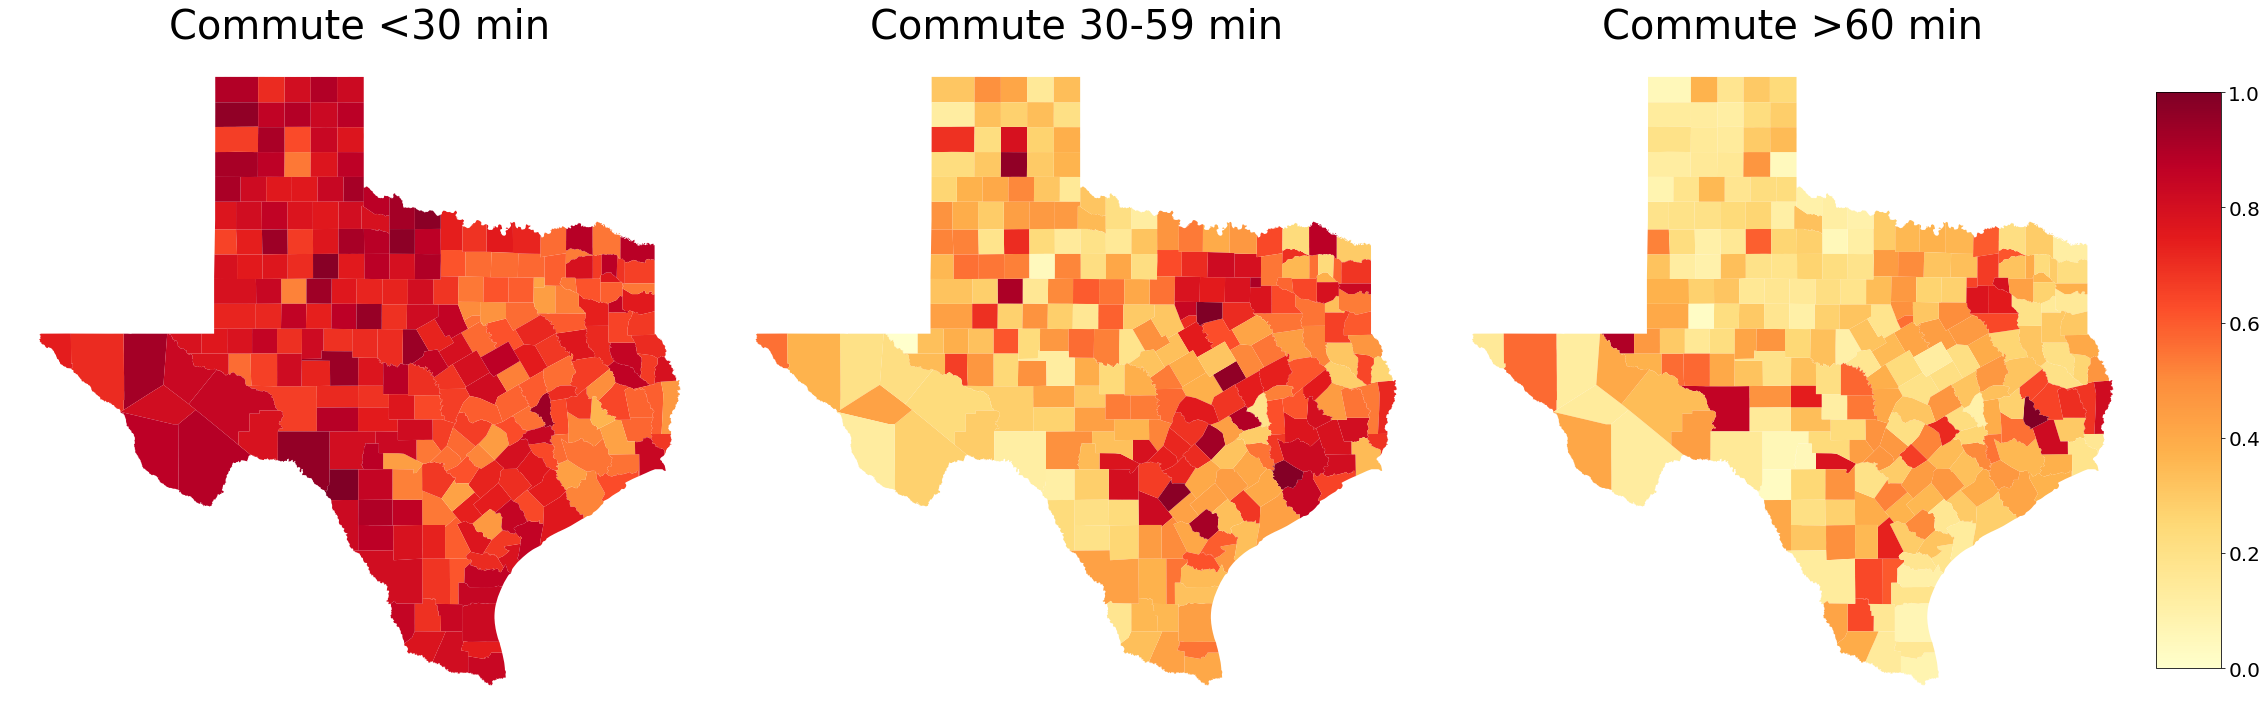

In [40]:
county_commute_shp = commute_choropleth(data_df=c2019, shp_df=county_shp, geo_type='county')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


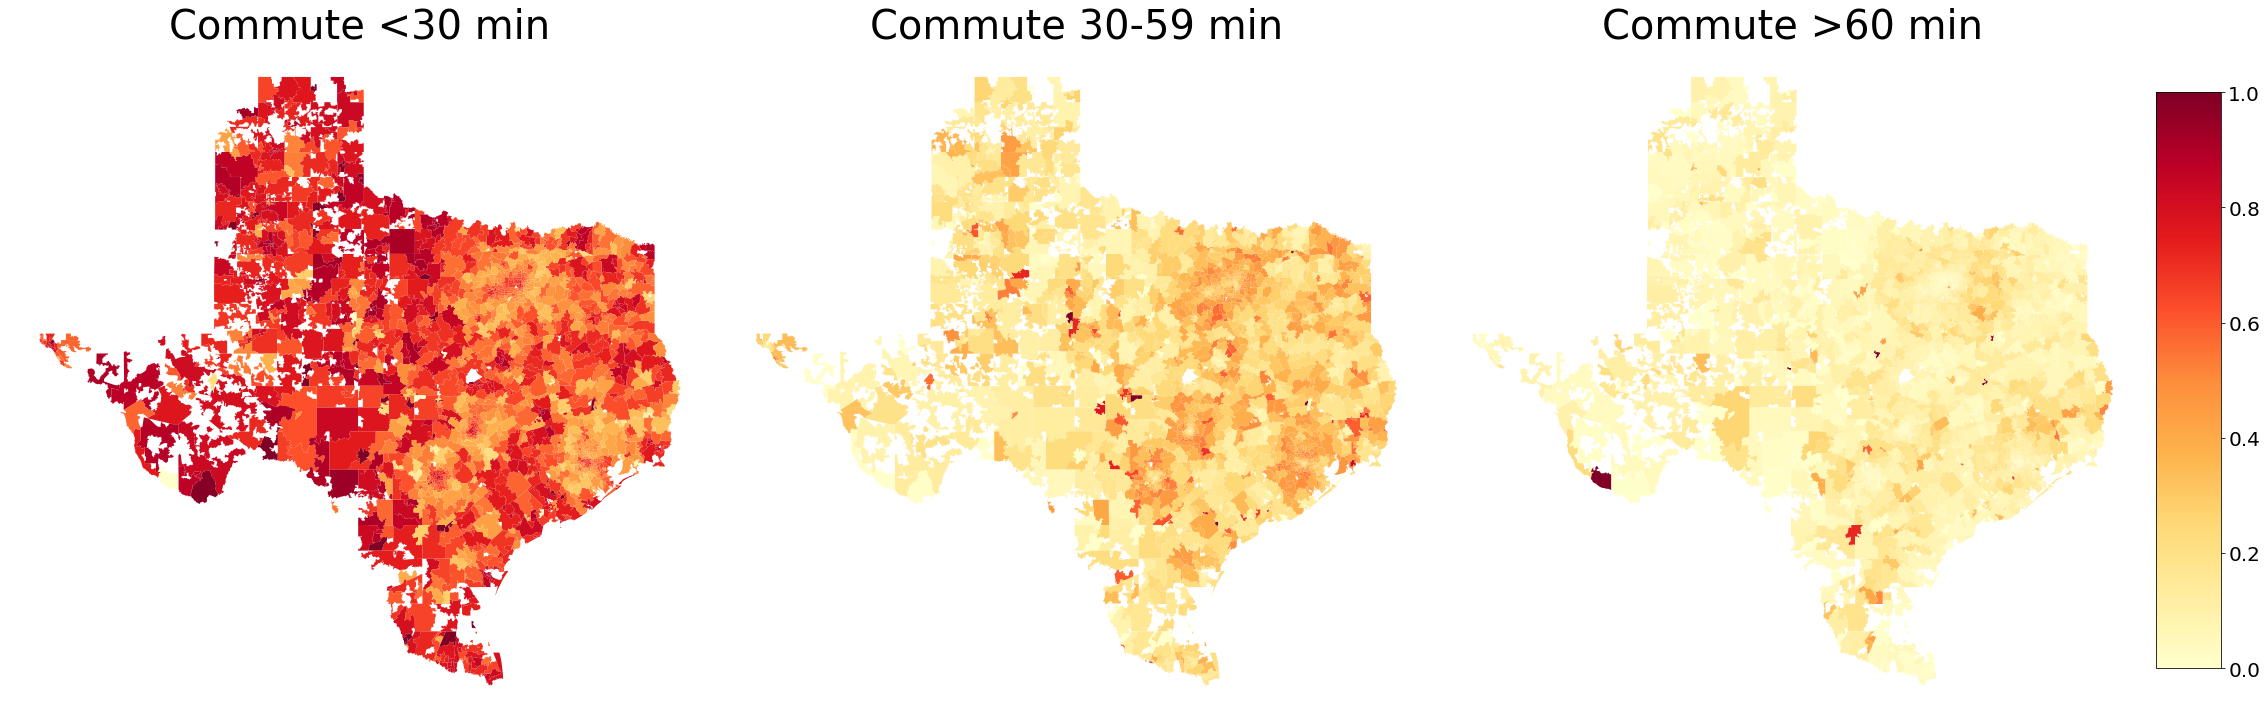

In [41]:
zcta_commute_shp = commute_choropleth(data_df=c2019, shp_df=zcta_shp, geo_type='zcta', shp_col='GEOID10')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


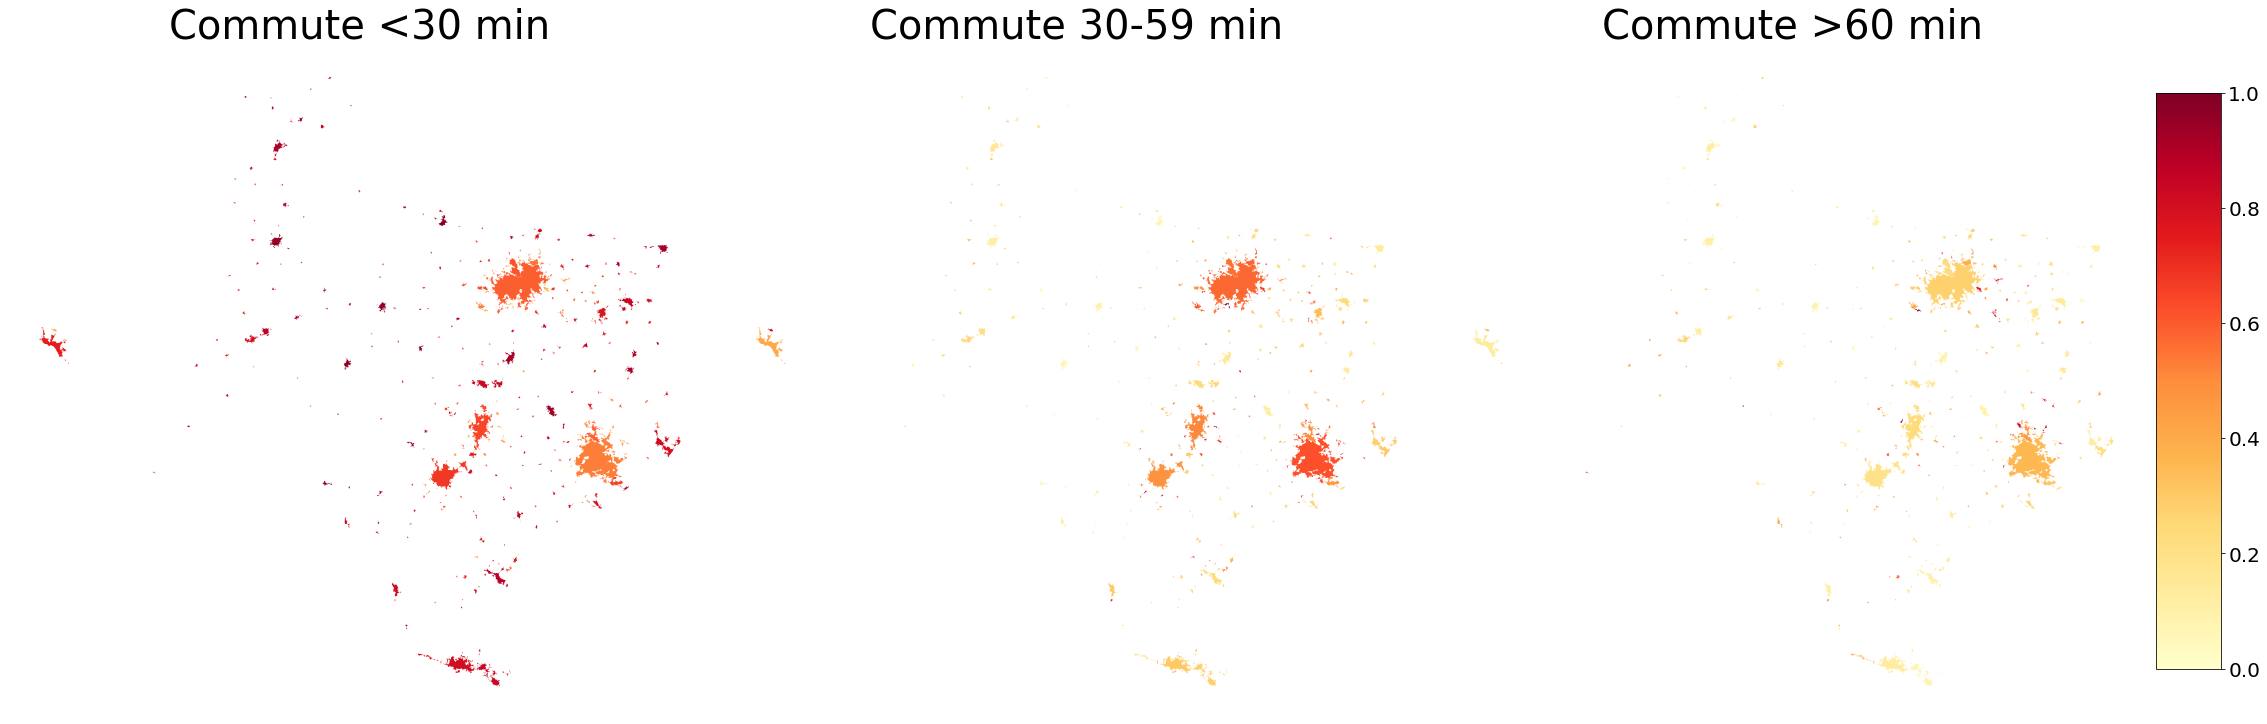

In [42]:
urban_commute_shp = commute_choropleth(data_df=c2019, shp_df=urban_shp, geo_type='urban', shp_col='GEOID10')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


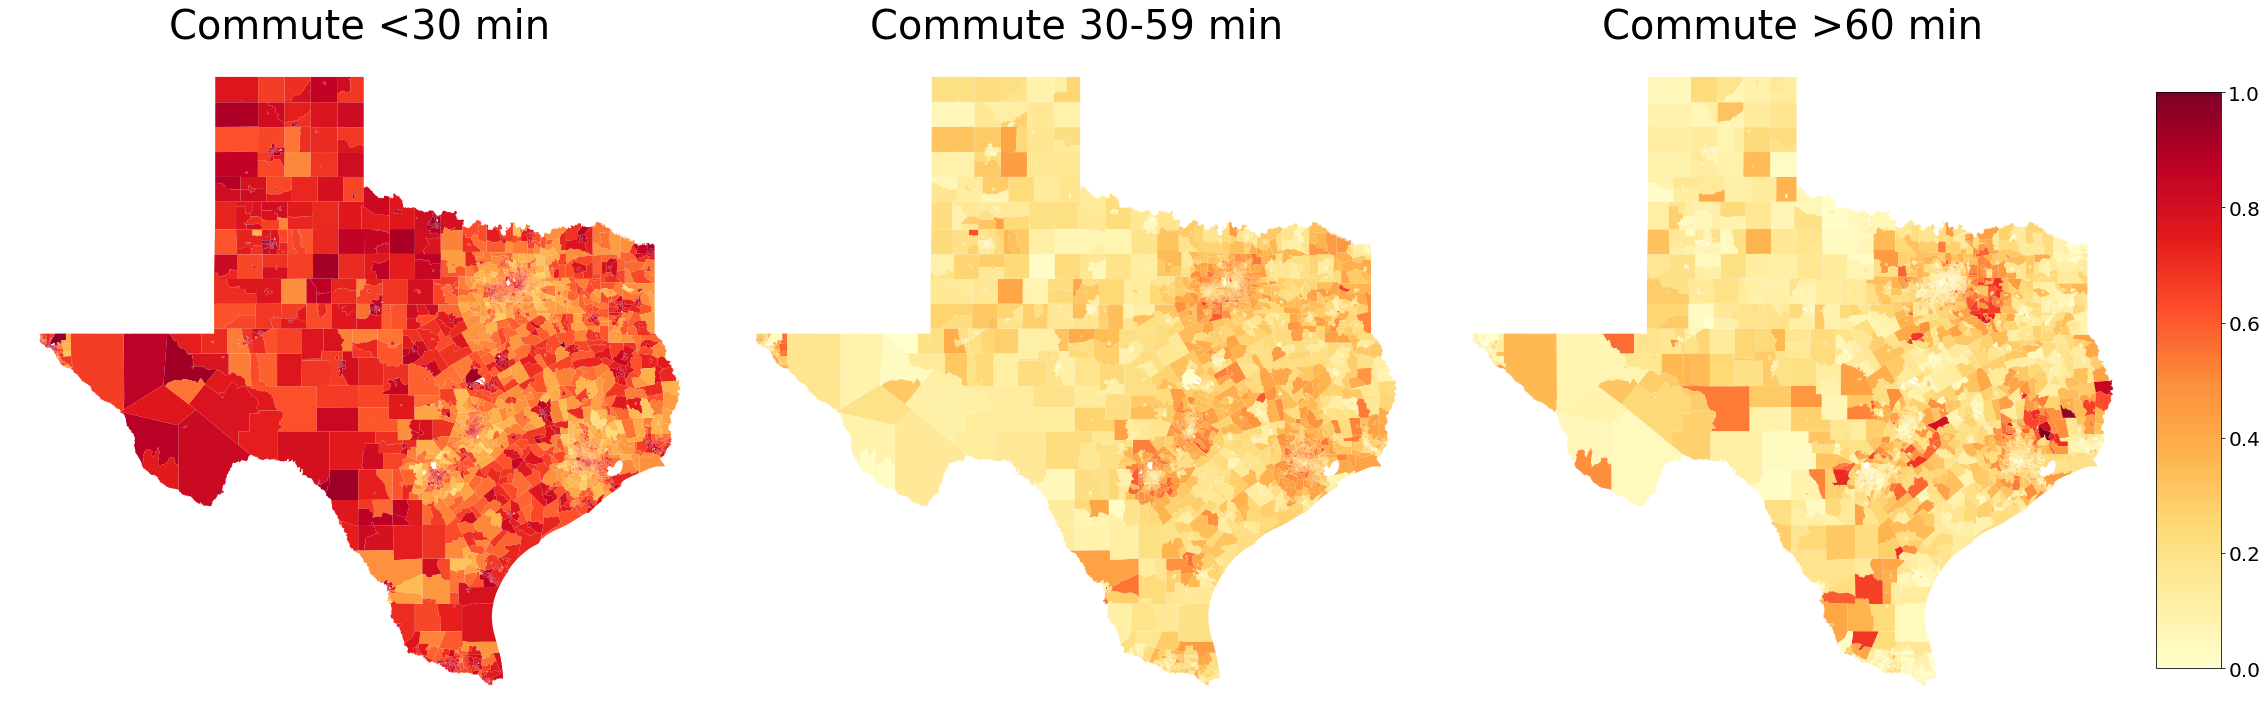

In [43]:
tract_commute_shp = commute_choropleth(data_df=c2019, shp_df=tract_shp, geo_type='tract', shp_col='GEOID')

/Users/kpierce/demographic-toolkit/demo-venv/lib/python3.7/site-packages/ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


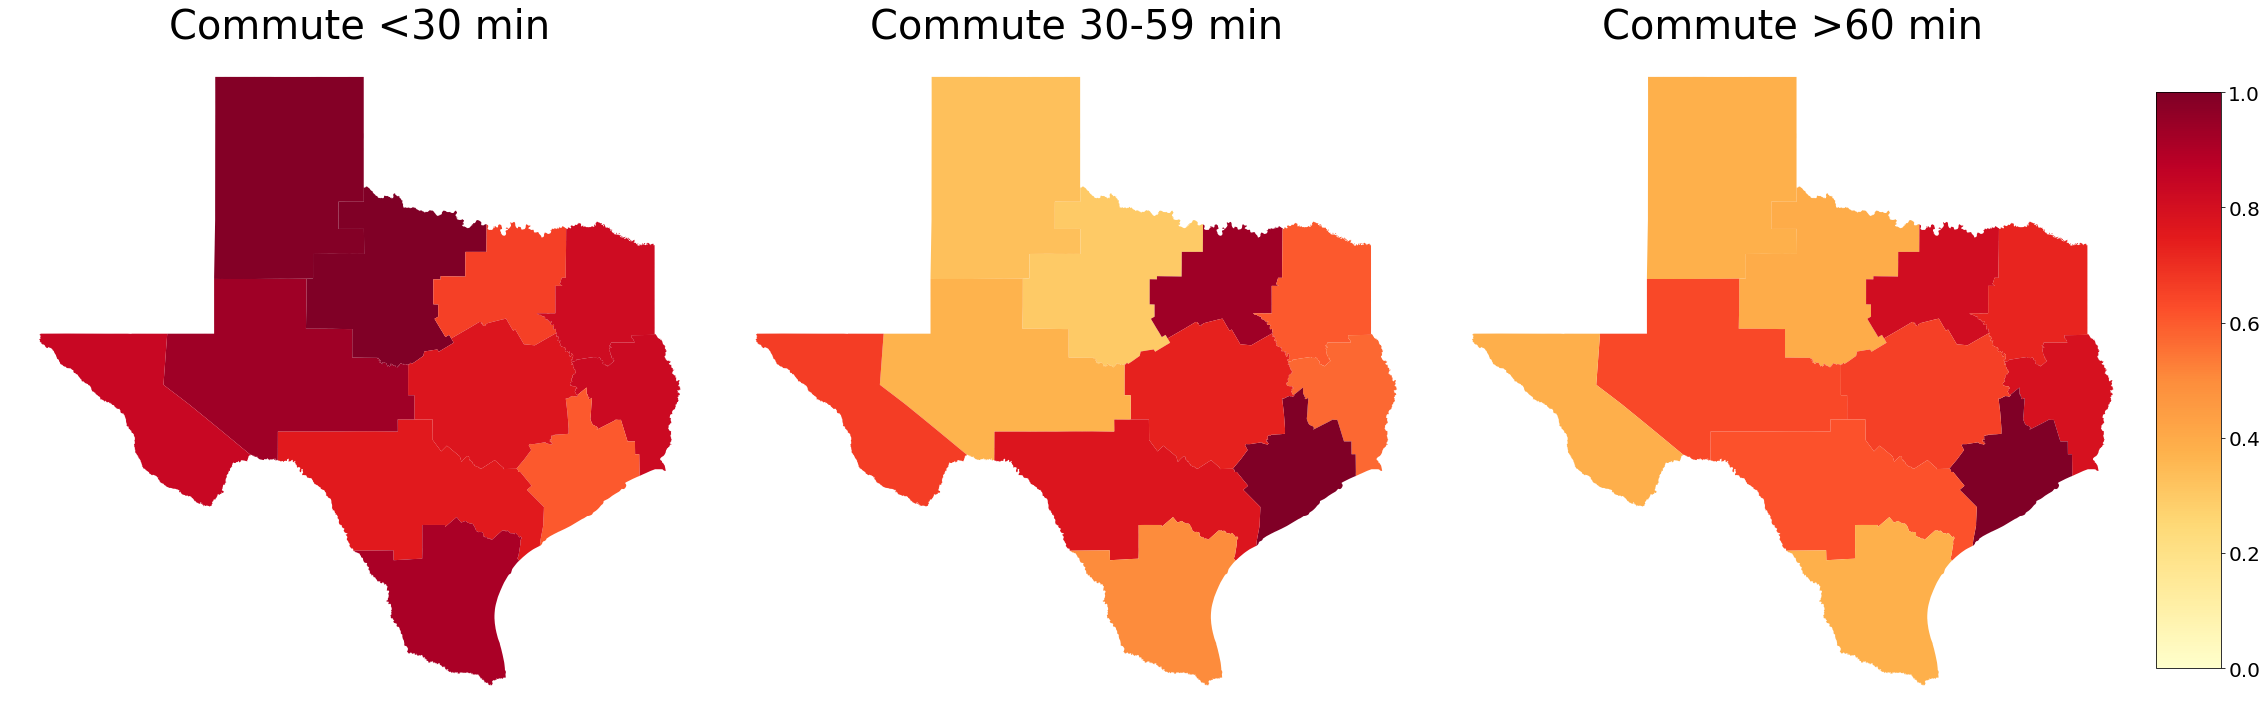

In [44]:
dfps_commute_shp = commute_choropleth(data_df=c2019, shp_df=dfps_shp, geo_type='dfps_region', shp_col='Sheet1__Re')

# Variables inspired by Opportunity Atlas

In [45]:
opportunity_2019 = aggregate_svi(
    '2019',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_zcta_other_census_vars_may2021_20210520143725.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_urban_area_other_census_vars_may2021_20210520143638.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_county_other_census_vars_may2021_20210520143028.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520143147.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2019_tract_other_census_vars_may2021_20210520143534.csv'
)

opportunity_2018 = aggregate_svi(
    '2018',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_zcta_other_census_vars_may2021_20210521192952.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_urban_area_other_census_vars_may2021_20210520123426.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_county_other_census_vars_may2021_20210520122801.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520122921.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2018_tract_other_census_vars_may2021_20210520123330.csv'
)

opportunity_2017 = aggregate_svi(
    '2017',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_zcta_other_census_vars_may2021_20210521193345.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_urban_area_other_census_vars_may2021_20210520103309.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_county_other_census_vars_may2021_20210520102704.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520102825.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2017_tract_other_census_vars_may2021_20210520103210.csv'
)

opportunity_2016 = aggregate_svi(
    '2016',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_zcta_other_census_vars_may2021_20210521193409.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_urban_area_other_census_vars_may2021_20210520083114.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_county_other_census_vars_may2021_20210520082522.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520082641.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2016_tract_other_census_vars_may2021_20210520083017.csv'
)

opportunity_2015 = aggregate_svi(
    '2015',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_zcta_other_census_vars_may2021_20210521193802.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_urban_area_other_census_vars_may2021_20210521194410.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_county_other_census_vars_may2021_20210520062052.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520062212.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2015_tract_other_census_vars_may2021_20210520062544.csv'
)

opportunity_2014 = aggregate_svi(
    '2014',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_zcta_other_census_vars_may2021_20210521193801.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_urban_area_other_census_vars_may2021_20210520042249.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_county_other_census_vars_may2021_20210520041701.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520041822.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2014_tract_other_census_vars_may2021_20210520042151.csv'
)

opportunity_2013 = aggregate_svi(
    '2013',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_zcta_other_census_vars_may2021_20210521194127.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_urban_area_other_census_vars_may2021_20210520021720.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_county_other_census_vars_may2021_20210520021107.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520021232.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2013_tract_other_census_vars_may2021_20210520021621.csv'
)

opportunity_2012 = aggregate_svi(
    '2012',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_zcta_other_census_vars_may2021_20210521194140.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_urban_area_other_census_vars_may2021_20210520001602.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_county_other_census_vars_may2021_20210520001024.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520001142.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2012_tract_other_census_vars_may2021_20210520001508.csv'
)

opportunity_2011 = aggregate_svi(
    '2011',
    zcta='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_zcta_other_census_vars_may2021_20210521194528.csv',
    urban='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_urban_area_other_census_vars_may2021_20210520000912.csv',
    county='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_county_other_census_vars_may2021_20210520000329.csv',
    cbsa='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_metropolitan_statistical_area_micropolitan_statistical_area_other_census_vars_may2021_20210520000450.csv',
    tract='/Users/kpierce/CooksProTX/other_census_aka_opportunity_atlas_data/_2011_tract_other_census_vars_may2021_20210520000814.csv'
)

In [46]:
update_cnames = {
    "Estimate, population": "E_TOTPOP",
    "Estimate, population (WHITE ALONE)": "E_WHITE_ALONE",
    "Estimate, population (BLACK OR AFRICAN AMERICAN ALONE)": "E_BLACK_AFRICAN_AMERICAN_ALONE",
    "Estimate, population (AMERICAN INDIAN AND ALASKA NATIVE ALONE)": "E_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE",
    "Estimate, population (ASIAN ALONE)": "E_ASIAN_ALONE",
    "Estimate, population (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE)": "E_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE",
    "Estimate, population (SOME OTHER RACE ALONE)": "E_OTHER_RACE_ALONE",
    "Estimate, population (TWO OR MORE RACES)": "E_TWO_OR_MORE_RACES",
    "Estimate, population (WHITE ALONE, NOT HISPANIC OR LATINO)": "E_WHITE_ALONE_NOT_HISPANIC_LATINO",
    "Estimate, population (HISPANIC OR LATINO)": "E_HISPANIC_LATINO",
    "Estimate, population (WHITE ALONE) PERCENT": "EP_WHITE_ALONE",
    "Estimate, population (BLACK OR AFRICAN AMERICAN ALONE) PERCENT": "EP_BLACK_AFRICAN_AMERICAN_ALONE",
    "Estimate, population (AMERICAN INDIAN AND ALASKA NATIVE ALONE) PERCENT": "EP_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE",
    "Estimate, population (ASIAN ALONE) PERCENT": "EP_ASIAN_ALONE",
    "Estimate, population (NATIVE HAWAIIAN AND OTHER PACIFIC ISLANDER ALONE) PERCENT": "EP_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE",
    "Estimate, population (SOME OTHER RACE ALONE) PERCENT": "EP_OTHER_RACE_ALONE",
    "Estimate, population (TWO OR MORE RACES) PERCENT": "EP_TWO_OR_MORE_RACES",
    "Estimate, population (WHITE ALONE, NOT HISPANIC OR LATINO) PERCENT": "EP_WHITE_ALONE_NOT_HISPANIC_LATINO",
    "Estimate, population (HISPANIC OR LATINO) PERCENT": "EP_HISPANIC_LATINO",
    "Estimate!!Total by place of birth": "E_TOTPOP_PLACE_OF_BIRTH",
    "Estimate!!Total!!Foreign born": "E_FOREIGN_BORN",
    "Estimate!!Total!!Foreign born PERCENT": "EP_FOREIGN_BORN",
    "Estimate!!Median gross rent as a percentage of household income": "E_MEDIAN_GROSS_RENT_PCT_HH_INCOME",
    "Estimate!!Total!!Housing units": "E_TOTAL_HU",
    "Estimate!!Total!!Renter-occupied housing units": "E_RENTER_OCCUPIED_HU",
    "Estimate!!Total!!Renter-occupied housing units PERCENT": "EP_RENTER_OCCUPIED_HU"
}
op_annual = [opportunity_2011, opportunity_2012, opportunity_2013, opportunity_2014, opportunity_2015, opportunity_2016, opportunity_2017, opportunity_2018, opportunity_2019]
op_full = pd.concat(op_annual)
op_full.columns = [i.strip() for i in op_full.columns]
op_full = op_full.rename(columns=update_cnames)

In [47]:
op_full.columns

Index(['GEOID', 'E_TOTPOP', 'E_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE',
       'E_ASIAN_ALONE', 'E_BLACK_AFRICAN_AMERICAN_ALONE', 'E_HISPANIC_LATINO',
       'E_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE', 'E_OTHER_RACE_ALONE',
       'E_TWO_OR_MORE_RACES', 'E_WHITE_ALONE_NOT_HISPANIC_LATINO',
       'E_WHITE_ALONE', 'E_MEDIAN_GROSS_RENT_PCT_HH_INCOME',
       'E_TOTPOP_PLACE_OF_BIRTH', 'E_FOREIGN_BORN', 'E_TOTAL_HU',
       'E_RENTER_OCCUPIED_HU', 'EP_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE',
       'EP_ASIAN_ALONE', 'EP_BLACK_AFRICAN_AMERICAN_ALONE',
       'EP_HISPANIC_LATINO', 'EP_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE',
       'EP_OTHER_RACE_ALONE', 'EP_TWO_OR_MORE_RACES',
       'EP_WHITE_ALONE_NOT_HISPANIC_LATINO', 'EP_WHITE_ALONE',
       'EP_FOREIGN_BORN', 'EP_RENTER_OCCUPIED_HU', 'YEAR', 'GEO_TYPE'],
      dtype='object')

In [48]:
opp_map = {
    'E_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE': 'E_TOTPOP',
    'E_ASIAN_ALONE': 'E_TOTPOP',
    'E_BLACK_AFRICAN_AMERICAN_ALONE': 'E_TOTPOP',
    'E_HISPANIC_LATINO': 'E_TOTPOP',
    'E_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE': 'E_TOTPOP',
    'E_OTHER_RACE_ALONE': 'E_TOTPOP',
    'E_TWO_OR_MORE_RACES': 'E_TOTPOP',
    'E_WHITE_ALONE_NOT_HISPANIC_LATINO': 'E_TOTPOP',
    'E_WHITE_ALONE': 'E_TOTPOP',
    'E_FOREIGN_BORN': 'E_TOTPOP_PLACE_OF_BIRTH',
    'E_RENTER_OCCUPIED_HU': 'E_TOTAL_HU'
}

op_dfps = []
for year in op_full['YEAR'].unique():
    
    county_df = op_full[(op_full['GEO_TYPE'] == 'county') & (op_full['YEAR'] == year)]

    # sum all the "E_" (estimate) columns
    agg_columns = [i for i in county_df.columns if re.match(r'^E_', i)]
    op_dfps.append(dfps_agg(county_df, agg_columns, opp_map))

op_dfps_df = pd.concat(op_dfps).drop('DFPS_Region', axis=1)

final_op = pd.concat([op_full, op_dfps_df])

In [49]:
final_op.head()


,GEOID,E_TOTPOP,E_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE,E_ASIAN_ALONE,E_BLACK_AFRICAN_AMERICAN_ALONE,E_HISPANIC_LATINO,E_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE,E_OTHER_RACE_ALONE,E_TWO_OR_MORE_RACES,E_WHITE_ALONE_NOT_HISPANIC_LATINO,...,EP_HISPANIC_LATINO,EP_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE,EP_OTHER_RACE_ALONE,EP_TWO_OR_MORE_RACES,EP_WHITE_ALONE_NOT_HISPANIC_LATINO,EP_WHITE_ALONE,EP_FOREIGN_BORN,EP_RENTER_OCCUPIED_HU,YEAR,GEO_TYPE
27359,75001,12510,34,686,1444,3908,136,891,149,6386,...,31.239009,1.087130,7.122302,1.191047,51.047162,73.301359,22.933653,75.995157,2011,zcta
27360,75002,62175,90,5272,6156,7954,0,1470,2375,41003,...,12.792923,0.000000,2.364294,3.819863,65.947728,75.290712,13.331725,17.643309,2011,zcta
27361,75006,45931,328,3206,3461,20752,0,2525,613,17989,...,45.180815,0.000000,5.497376,1.334611,39.165270,77.938647,29.801224,42.705939,2011,zcta
27362,75007,50921,593,6820,4542,10969,30,1634,1713,26977,...,21.541211,0.058915,3.208892,3.364034,52.978143,69.890615,20.836197,23.681908,2011,zcta
27363,75009,8418,207,0,112,1727,0,505,207,6331,...,20.515562,0.000000,5.999050,2.459016,75.207888,87.752435,8.600618,21.064140,2011,zcta


In [50]:
op_dfps_df['GEO_TYPE'].unique()

array(['dfps_region'], dtype=object)

In [51]:
final_op[final_op['GEO_TYPE'] == 'dfps_region']

,GEOID,E_TOTPOP,E_AMERICAN_INDIAN_ALASKA_NATIVE_ALONE,E_ASIAN_ALONE,E_BLACK_AFRICAN_AMERICAN_ALONE,E_HISPANIC_LATINO,E_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE,E_OTHER_RACE_ALONE,E_TWO_OR_MORE_RACES,E_WHITE_ALONE_NOT_HISPANIC_LATINO,...,EP_HISPANIC_LATINO,EP_NATIVE_HAWAIIAN_OTHER_PACIFIC_ISLANDER_ALONE,EP_OTHER_RACE_ALONE,EP_TWO_OR_MORE_RACES,EP_WHITE_ALONE_NOT_HISPANIC_LATINO,EP_WHITE_ALONE,EP_FOREIGN_BORN,EP_RENTER_OCCUPIED_HU,YEAR,GEO_TYPE
0,1-Lubbock,830988,4923,13993,44867,280960,712,60581,23691,477517,...,33.810356,0.085681,7.290238,2.850944,57.463766,82.097575,8.875940,34.197326,2011,dfps_region
1,2-Abilene,547993,3189,6011,35546,106086,252,25869,12036,390960,...,19.359006,0.045986,4.720681,2.196378,71.343977,84.871522,5.128715,30.739435,2011,dfps_region
2,3-Arlington,6639535,36959,334599,949326,1755820,6978,547385,157809,3470427,...,26.444924,0.105098,8.244327,2.376808,52.269127,69.379542,16.759321,37.028807,2011,dfps_region
3,4-Tyler,1103445,6331,7529,173813,142368,949,30812,16137,763257,...,12.902138,0.086003,2.792346,1.462420,69.170371,78.651315,6.671107,28.047762,2011,dfps_region
4,5-Beaumont,763468,3097,12038,154335,95998,352,28457,10636,490883,...,12.573939,0.046105,3.727334,1.393117,64.296473,72.636050,6.442313,28.654564,2011,dfps_region
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6,7-Austin,3442468,17721,157024,351688,995927,4816,177623,121106,1861693,...,28.930610,0.139900,5.159757,3.517999,54.080183,75.890030,12.642151,40.551394,2019,dfps_region
7,8-San Antonio,2931762,18685,65774,182355,1632624,3016,172718,91514,1005844,...,55.687467,0.102873,5.891269,3.121468,34.308515,81.783583,11.997973,36.362650,2019,dfps_region
8,9-Midland,644907,3791,7948,30240,321092,334,56457,15687,277897,...,49.788884,0.051790,8.754286,2.432444,43.091019,82.252170,12.267970,32.632791,2019,dfps_region
9,10-El Paso,861138,5647,10732,28010,706148,1133,105114,22656,108291,...,82.001723,0.131570,12.206406,2.630937,12.575336,79.876396,24.113789,38.821775,2019,dfps_region


In [52]:
final_op.to_csv('/Users/kpierce/CooksProTX/final_demographic_data/opportunity_atlas_by_year/opportunity_data.csv')
